In [180]:
# cтандартные python библиотеки
import os
import time

# базовые DS библиотеки
import numpy as np 
import pandas as pd


# библиотеки визуализации
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

# функции для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# библиотеки для кодирования данных
import category_encoders as ce

# статистические тесты
from scipy.stats import normaltest # Тест на нормальность Д'Агостино
import scipy.stats as stats

# для подсчета тегов
from collections import Counter

# Для анализа тональности текста
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer



In [181]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [182]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 1. Загрузка данных и проверка структуры.

In [183]:
# Подгрузим наши данные из соревнования

#DATA_DIR = '/kaggle/input/sf-booking/'
#DATA_DIR = 'data/'
df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн

In [184]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [185]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [186]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [187]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_train, df_test], ignore_index=True)
data['sample'] = data['sample'].astype('category') # признак 'sample' категориальный


In [188]:
# выводим информацию по объединенному dataset
display(data.info())
display(data.describe())
display(data.describe(include=object))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   hotel_address                               515738 non-null  object  
 1   additional_number_of_scoring                515738 non-null  int64   
 2   review_date                                 515738 non-null  object  
 3   average_score                               515738 non-null  float64 
 4   hotel_name                                  515738 non-null  object  
 5   reviewer_nationality                        515738 non-null  object  
 6   negative_review                             515738 non-null  object  
 7   review_total_negative_word_counts           515738 non-null  int64   
 8   total_number_of_reviews                     515738 non-null  int64   
 9   positive_review                             515738 non-null

None

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,6.297672,49.442439,2.823803
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.902295,3.466325,4.579425
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.625000,48.214662,-0.143372
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,7.900000,51.499981,0.010607
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233


,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,515738,515738,515738,515738,515738,515738,515738,515738
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,4789,2585,4789,245246,127890,35946,5101,2585


Комментарии:

- Объединенный dataset имеет размерность 515738 строк, 18 признаков;
- Признаки имеют тип данных: float64(4), int64(5), object(8), category(1).

## 2. Очистка данных.

lat    0.633655
lng    0.633655
dtype: float64

<Axes: >

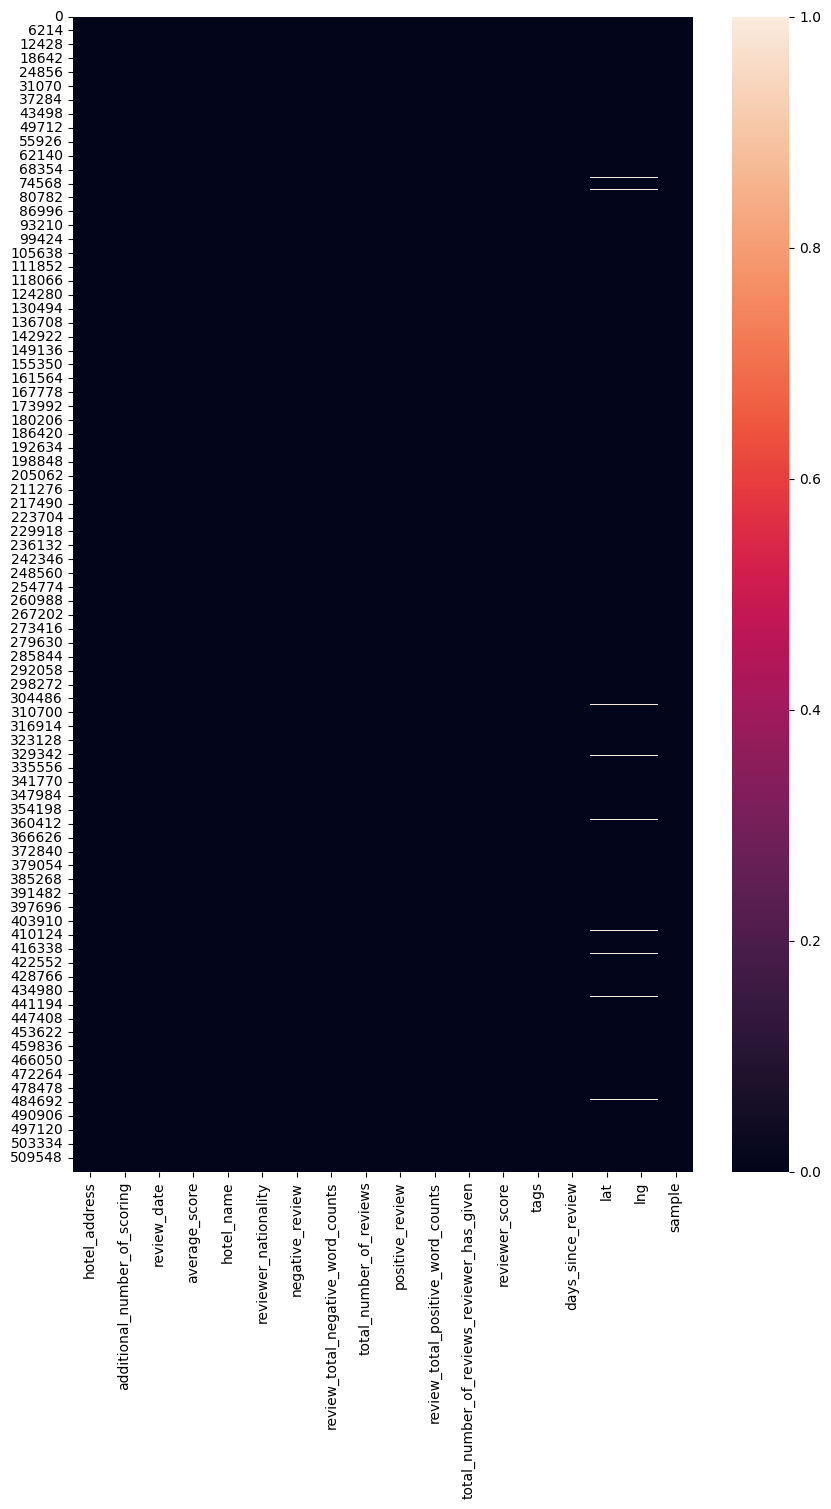

In [189]:
# формируем и выводим информацию о наличие пропусков в признаках (%) 
cols_null_percent = data.isnull().mean() * 100 # все признаки с  пропусками в (%) 
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False) # признаки с наличием пропусков (%)
display(cols_with_null)
# display(cols_null_percent)
sns.heatmap(data.isnull()) # наглядная карта пропусков. Пропусков немного.

In [190]:
# подсчитаем к-во пропусков о в признаках 
cols_null = data.isna().sum() # где пропуск там True=1.
display(cols_null[cols_null > 0])

lat    3268
lng    3268
dtype: int64

In [191]:
# информация о уникальных значений с пропусками
hotels_isnull = data[data['lat'].isnull() | data['lng'].isnull()] # записи с пропусками где либо
list_null = hotels_isnull[['hotel_name', 'hotel_address']] # выбираем датафрейм с двумя колонками у таких записей
list_isnull = hotels_isnull['hotel_name'].value_counts()
display(list_isnull)
display(f'Всего {len(list_isnull)}- таких уникальных записей с пропусками')

hotel_name
Fleming s Selection Hotel Wien City                 658
Hotel City Central                                  563
Hotel Atlanta                                       389
Maison Albar Hotel Paris Op ra Diamond              290
Hotel Daniel Vienna                                 245
Hotel Pension Baron am Schottentor                  223
Austria Trend Hotel Schloss Wilhelminenberg Wien    194
Derag Livinghotel Kaiser Franz Joseph Vienna        147
NH Collection Barcelona Podium                      146
City Hotel Deutschmeister                            93
Hotel Park Villa                                     61
Cordial Theaterhotel Wien                            57
Holiday Inn Paris Montmartre                         55
Roomz Vienna                                         49
Mercure Paris Gare Montparnasse                      37
Renaissance Barcelona Hotel                          33
Hotel Advance                                        28
Name: count, dtype: int64

'Всего 17- таких уникальных записей с пропусками'

Комментарии:

- Пропуски содержатся в 2х признаках "lat" и "lng", количество записей составляет 3268 в каждом признаке или 0,63%;
- Количество уникальных записей - 17, по которым не заполнена информация по широте и долготе;

In [192]:
# формируем словарь с данными по широте
dict_lat = {'Austria Trend Hotel Schloss Wilhelminenberg Wien': '48.219547925972456', 
                'Holiday Inn Paris Montmartre': '48.889064368690235',
                'Fleming s Selection Hotel Wien City': '48.209427104128665',
                'Hotel Atlanta': '48.2209723965124',
                'Maison Albar Hotel Paris Op ra Diamond': '48.87543722920124',
                'Derag Livinghotel Kaiser Franz Joseph Vienna': '48.24608017805536',
                'Hotel City Central': '48.214201786014854',
                'NH Collection Barcelona Podium': '41.39176529029773',
                'City Hotel Deutschmeister': '48.22103057609981',
                'Hotel Daniel Vienna': '48.18897212994251',
                'Roomz Vienna': '48.22382961585223',
                'Hotel Pension Baron am Schottentor': '48.21692824899107',
                'Mercure Paris Gare Montparnasse': '48.84010021974514',
                'Hotel Park Villa': '48.23759024291264',
                'Hotel Advance': '41.38327316014033',
                'Renaissance Barcelona Hotel': '41.394162363243964',
                'Cordial Theaterhotel Wien': '48.20969901650749'}

In [193]:
# формируем словарь с данными по долготе
dict_lng = {'Austria Trend Hotel Schloss Wilhelminenberg Wien': '16.285565274761424', 
                'Holiday Inn Paris Montmartre': '2.333206641604505',
                'Fleming s Selection Hotel Wien City': '16.353540496647103',
                'Hotel Atlanta': '16.356650516337886',
                'Maison Albar Hotel Paris Op ra Diamond': '2.3234027262612256',
                'Derag Livinghotel Kaiser Franz Joseph Vienna': '16.34202545691955',
                'Hotel City Central': '16.379923233140797',
                'NH Collection Barcelona Podium': '2.1783660658934747',
                'City Hotel Deutschmeister': '16.366622226233126',
                'Hotel Daniel Vienna': '16.3838329415743',
                'Roomz Vienna': '16.393969343883455',
                'Hotel Pension Baron am Schottentor': '16.360055901096636',
                'Mercure Paris Gare Montparnasse': '2.3231778953046462',
                'Hotel Park Villa': '16.34703938556462',
                'Hotel Advance': '2.162964217594162',
                'Renaissance Barcelona Hotel': '2.1748749075722924',
                'Cordial Theaterhotel Wien': '16.351495483903957'}

In [194]:
# формируем код и производим заполнение данных в dataframe
data['lat'] = data.apply(lambda x: dict_lat.get(x['hotel_name']) if pd.isnull(x['lat']) else x['lat'], axis=1).astype('float64') # вводим данные по широте и устанавливаем тип float64
data['lng'] = data.apply(lambda x: dict_lng.get(x['hotel_name']) if pd.isnull(x['lng']) else x['lng'], axis=1).astype('float64') # вводим данные по долготе и устанавливаем тип float64

In [195]:
#cols_null = hotels.isna().sum() # где пропуск там True=1.
display(data.info())
hotels_isnull = data[data['lat'].isnull() | data['lng'].isnull()] # записи с пропусками где либо
list_null = hotels_isnull[['hotel_name', 'hotel_address']] # выбираем датафрейм с двумя колонками у таких записей
list_isnull = hotels_isnull['hotel_name'].value_counts()
#display(list_isnull)
display(f'Всего {len(list_isnull)}- таких записей с пропусками')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   hotel_address                               515738 non-null  object  
 1   additional_number_of_scoring                515738 non-null  int64   
 2   review_date                                 515738 non-null  object  
 3   average_score                               515738 non-null  float64 
 4   hotel_name                                  515738 non-null  object  
 5   reviewer_nationality                        515738 non-null  object  
 6   negative_review                             515738 non-null  object  
 7   review_total_negative_word_counts           515738 non-null  int64   
 8   total_number_of_reviews                     515738 non-null  int64   
 9   positive_review                             515738 non-null

None

'Всего 0- таких записей с пропусками'

Комментарии:

- Пропусков нет.

### 2.1 Обработка дубликатов.

In [196]:
# формируем и выводим информацию о наличие дубликатов
hotels_dublicate = data[data.duplicated()]
display(f'Количество дубликатов в dataset составляет {hotels_dublicate.shape[0]} шт.')

'Количество дубликатов в dataset составляет 336 шт.'

In [197]:
# Названия Отелей у которых есть дубликаты и как много дубликатов
hotels_dublicate['hotel_name'].value_counts()

hotel_name
H tel Concorde Montparnasse               235
H tel Baume                                50
Hotel Le Sainte Beuve                      35
Villa Eugenie                               9
Pertschy Palais Hotel                       1
The Bloomsbury Hotel                        1
Hotel Da Vinci                              1
Mercure Paris Centre Tour Eiffel            1
Park Plaza Vondelpark Amsterdam             1
Fletcher Hotel Amsterdam                    1
Copthorne Tara Hotel London Kensington      1
Name: count, dtype: int64

In [198]:
# информация о % дубликатов к общему количеству записей для отелей первых 4 позиций.
index_1 = (hotels_dublicate[hotels_dublicate['hotel_name'] == 'H tel Concorde Montparnasse'].shape[0] / data[data['hotel_name'] == 'H tel Concorde Montparnasse'].shape[0])*100
display(f'Количество дубликатов по отелю "H tel Concorde Montparnasse" составляет {round(index_1, 2)}% от к-ва записей по этому отелю.')

index_2 = (hotels_dublicate[hotels_dublicate['hotel_name'] == 'H tel Baume'].shape[0] / data[data['hotel_name'] == 'H tel Baume'].shape[0])*100
display(f'Количество дубликатов по отелю "H tel Baume" составляет {round(index_2, 2)}% от к-ва записей по этому отелю.')

index_3 = (hotels_dublicate[hotels_dublicate['hotel_name'] == 'Hotel Le Sainte Beuve'].shape[0] / data[data['hotel_name'] == 'Hotel Le Sainte Beuve'].shape[0])*100
display(f'Количество дубликатов по отелю "Hotel Le Sainte Beuve" составляет {round(index_3, 2)}% от к-ва записей по этому отелю.')

index_4 = (hotels_dublicate[hotels_dublicate['hotel_name'] == 'Villa Eugenie'].shape[0] / data[data['hotel_name'] == 'Villa Eugenie'].shape[0])*100
display(f'Количество дубликатов по отелю "Villa Eugenie" составляет {round(index_4, 2)}% от к-ва записей по этому отелю.')

'Количество дубликатов по отелю "H tel Concorde Montparnasse" составляет 33.96% от к-ва записей по этому отелю.'

'Количество дубликатов по отелю "H tel Baume" составляет 28.41% от к-ва записей по этому отелю.'

'Количество дубликатов по отелю "Hotel Le Sainte Beuve" составляет 35.71% от к-ва записей по этому отелю.'

'Количество дубликатов по отелю "Villa Eugenie" составляет 14.52% от к-ва записей по этому отелю.'

In [199]:
# формируем и выводим информацию о количестве дубликатов в выборке train и test
hotels_dublicate_train = data[data['sample'] == 1]
hotels_dublicate_test = data[data['sample'] == 0]

display(f'Количество дубликатов в выборке train: {hotels_dublicate_train[hotels_dublicate_train.duplicated()].shape[0]}.')
display(f'Количество дубликатов в выборке test: {hotels_dublicate_test[hotels_dublicate_test.duplicated()].shape[0]}.')

'Количество дубликатов в выборке train: 307.'

'Количество дубликатов в выборке test: 29.'

Комментарии:

- Общее количество дубликатов в dataset составляет 336 записей или 0,07% от общего количества;
- Есть четыре отеля по которым дубликаты составляют от 14.52% до 35.71% от записей по этим же отелям, возможно, это програмные или организованные методы создания оценок- манипуляции;
- Удалим дубликаты, только из записей из выборки train (признак 'sample' = 1).
- Выявлены ошибки в имени 2х отелей, исправим их.

In [200]:
# исправим ошибки в названиях двух отелей.
replace_dict = {'H tel Concorde Montparnasse':'Hotel Concorde Montparnasse', 'H tel Baume':'Hotel Baume'}
data['hotel_name'] = data['hotel_name'].replace(replace_dict)

In [201]:
# делим dataframe на 2 выборки и удаляем дубликаты только в train, т.к тестовую выборку нельзя уменьшать,
# тогда не будет соответствия по к-ву записей submission.
#dublicate_tr = hotels.query('sample == 1').drop_duplicates()
dublicate_ts = data[data['sample'] == 0]
dublicate_tr = data[data['sample'] == 1].drop_duplicates()

In [202]:
# объединяем dataframes, опять
data = pd.concat([dublicate_ts, dublicate_tr], ignore_index=True)

In [203]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   hotel_address                               515431 non-null  object  
 1   additional_number_of_scoring                515431 non-null  int64   
 2   review_date                                 515431 non-null  object  
 3   average_score                               515431 non-null  float64 
 4   hotel_name                                  515431 non-null  object  
 5   reviewer_nationality                        515431 non-null  object  
 6   negative_review                             515431 non-null  object  
 7   review_total_negative_word_counts           515431 non-null  int64   
 8   total_number_of_reviews                     515431 non-null  int64   
 9   positive_review                             515431 non-null

Датафрейм уменьшился на 307 строк, к-во дубликатов в train выборке.

### 2.2 Дата, когда посетитель оставил отзыв.

In [204]:
data['review_date'] = pd.to_datetime(data['review_date'])

data['review_year'] = data['review_date'].dt.year
data['review_month'] = data['review_date'].dt.month
data['review_day'] = data['review_date'].dt.day
data['review_dayofweek'] = data['review_date'].dt.dayofweek
data['review_week'] = data['review_date'].dt.isocalendar().week.astype('int')

In [205]:
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,tags,days_since_review,lat,lng,sample,review_year,review_month,review_day,review_dayofweek,review_week
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,2017,7,21,4,29
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,2016,12,12,0,50
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,2015,11,26,3,48
3,Piazza Della Repubblica 17 Central Station 201...,241,2015-10-17,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,...,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,2015,10,17,5,42
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,2016-05-16,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,...,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,2016,5,16,0,20


Сортировка отзывов:

In [206]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [207]:
# Создаём объекты SentimentIntensityAnalyzer
positive_analyzer = SentimentIntensityAnalyzer()
negative_analyzer = SentimentIntensityAnalyzer()

# Посмотрим, как изменится характеристика слова 'nothing'
example_word = 'nothing'
print(f'Словарь оценок слова "{example_word}" до преобразований:')
print(negative_analyzer.polarity_scores(example_word), '\n')

# Добавим контекст
negative_words = {'small': -1, 'nothing': 10}
positive_words = {'nothing': -10, 'everything': 10}

negative_analyzer.lexicon.update(negative_words)
positive_analyzer.lexicon.update(positive_words)

print(f' - после преобразований (для негативного контекста):')
print(negative_analyzer.polarity_scores(example_word))
print(f' - после преобразований (для позитивного контекста):')
print(positive_analyzer.polarity_scores(example_word))

# Пример с фразами "No Negative" и "Positive"
phrases = ['No Negative', 'Positive']
for phrase in phrases:
    print(f'\nСловарь оценок фразы "{phrase}":')
    print(negative_analyzer.polarity_scores(phrase))

# Обновление меток отсутствия частей отзыва
# Определяем словарь замен
replacements = {
    'No Negative': 'Positive',
    'N A': 'Positive',
    'All good': 'Positive',
    'No complaints': 'Positive',
    'Nothing to dislike': 'Positive',
    'No Positive': 'Negative'
}

# Функция для замены значений
def replace_phrases(text, replacements):
    for old, new in replacements.items():
        text = text.replace(old, new)
    return text

# Применяем функцию к столбцам
data['negative_review_word'] = data['negative_review'].apply(lambda x: replace_phrases(x, replacements))
data['positive_review_word'] = data['positive_review'].apply(lambda x: replace_phrases(x, replacements))

Словарь оценок слова "nothing" до преобразований:
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} 

 - после преобразований (для негативного контекста):
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.9325}
 - после преобразований (для позитивного контекста):
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.9325}

Словарь оценок фразы "No Negative":
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}

Словарь оценок фразы "Positive":
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5574}


In [208]:
%%time

# Функция для извлечения оценок
def get_compliment(data, text_column, analyzer, prefix):
    compliment = data[text_column].apply(analyzer.polarity_scores).apply(pd.Series)
    compliment.columns = [f'{prefix}_{col}' for col in compliment.columns]
    return compliment

# Получаем оценки для негативных отзывов
negative_compliment = get_compliment(data, 'negative_review_word', negative_analyzer, 'neg_review_compliment')
# Получаем оценки для позитивных отзывов
positive_compliment = get_compliment(data, 'positive_review_word', positive_analyzer, 'pos_review_compliment')

# Объединяем результаты с исходным DataFrame
data = pd.concat([data, negative_compliment, positive_compliment], axis=1)

CPU times: total: 12min 42s
Wall time: 15min 1s


##### 1. Количество слов в положительном отзыве ('review_total_positive_word_counts'),
##### 2. Количество слов в отрицательном отзыв ('review_total_negative_word_counts').

In [209]:
words_negative = ['no negative', 'nothing', 'n a', 'none', '', 'all good', 
                       'nothing really', 'no complaints', 'nil', 'Nothing to dislike',
                       'nothing at all', 'na', 'can t think of anything']
words_positive = ['no positive', 'nothing']

data['review_total_negative_word_counts'] = \
    data['negative_review'].apply(lambda x: 0 if x.strip().lower() in words_negative else len(x.split()))
data['review_total_positive_word_counts'] = \
    data['positive_review'].apply(lambda x: 0 if x.strip().lower() in words_positive else len(x.split()))

In [210]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 33 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   additional_number_of_scoring                515431 non-null  int64         
 2   review_date                                 515431 non-null  datetime64[ns]
 3   average_score                               515431 non-null  float64       
 4   hotel_name                                  515431 non-null  object        
 5   reviewer_nationality                        515431 non-null  object        
 6   negative_review                             515431 non-null  object        
 7   review_total_negative_word_counts           515431 non-null  int64         
 8   total_number_of_reviews                     515431 non-null  int64        

### 2.3.  Анализ тегов.

In [211]:

#import category_encoders as ce
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

from collections import Counter
#from geopy import distance
#from geopy.geocoders import Nominatim
from itertools import chain

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Import data set splitting function
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# импортируем библиотеки для оценки тональности отзывов
#import nltk
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
#nltk.downloader.download('vader_lexicon')

#импортируем библиотеки для кодирования признаков
#import category_encoders as ce

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

In [212]:
import re

# количество тегов
data['tag_count'] = data['tags'].apply(lambda x: len(re.findall("'[^\'](.+?)[^\']'", x)))

In [213]:
# количество тегов
def get_tag(tag_string):
    # Удаляем ненужные символы
    tag_string = tag_string.strip("[]").replace("' ", '').replace(" '", '')
    tag_list = [tag.strip() for tag in tag_string.split(',')]

    reviewer_type = {
        'Solo traveler': 1,
        'Couple': 2,
        'Travelers with friends': 3,
        'Family with young children': 4,
        'Family with older children': 5,
        'Group': 6
    }

    room_type = {
        'without Window': 0,
        'Guestroom': 1,
        'Classic': 2,
        'Single': 3,
        'Standard': 4,
        'Superior': 5,
        'Comfort': 6,
        'Club': 7,
        'Suite': 8,
        'Deluxe': 9,
        'King': 10,
        'Premier': 11
    }

    tag_from_mobile = 0
    tag_with_pet = 0
    tag_leisure_trip = 1
    tag_reviewer_type = 0
    tag_count_nights = 0
    tag_view_room = 0
    tag_room_type = -1

    for tag in tag_list:
        if tag == 'Submitted from a mobile device':
            tag_from_mobile = 1
        elif tag == 'With a pet':
            tag_with_pet = 1
        elif tag == 'Business trip':
            tag_leisure_trip = 0
        elif tag == 'Leisure trip':
            tag_leisure_trip = 1
        elif tag in reviewer_type:
            tag_reviewer_type = reviewer_type[tag]
        elif re.fullmatch(r'Stayed\s\d+\snight\w?', tag):
            tag_count_nights = int(re.findall(r'\d+', tag)[0])
        elif 'View' in tag or 'Panoramic' in tag:
            tag_view_room = 1
        elif tag in room_type:
            tag_room_type = room_type[tag]
        elif 'Double' in tag or 'Twin' in tag:
            tag_room_type = 12

    if tag_room_type == -1:
        tag_room_type = 13

    return pd.Series([tag_from_mobile, tag_with_pet, tag_leisure_trip,
                      tag_reviewer_type, tag_count_nights, tag_view_room,
                      tag_room_type])

# Применяем функцию и создаем новые столбцы
data[['tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip',
        'tag_reviewer_type', 'tag_count_nights', 'tag_view_room',
        'tag_room_type']] = data['tags'].apply(get_tag)

In [214]:
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,pos_review_compliment_pos,pos_review_compliment_compound,tag_count,tag_from_mobile,tag_with_pet,tag_leisure_trip,tag_reviewer_type,tag_count_nights,tag_view_room,tag_room_type
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,50,16670,Hotel was great clean friendly staff free bre...,...,0.329,0.9615,4,0,0,1,2,2,0,12
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,9,5018,No Positive,...,0.000,-0.5719,4,0,0,1,6,1,0,13
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,1,351,Nice welcoming and service,...,0.740,0.6908,5,1,0,0,1,1,0,12
3,Piazza Della Repubblica 17 Central Station 201...,241,2015-10-17,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,...,0.543,0.9794,4,0,0,1,2,1,0,13
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,2016-05-16,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,...,0.770,0.7717,5,1,0,0,1,2,0,12


##  3. Признак "tags".


In [215]:
# выводим информацию о структуре
display(data['tags'].iloc[500])
display(data['tags'].iloc[12000])
display(data['tags'].iloc[350000])

"[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 2 nights ']"

"[' Business trip ', ' Group ', ' 3 rooms ', ' Stayed 1 night ']"

"[' Leisure trip ', ' Family with older children ', ' Privilege Family Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']"

Комментарии / выводы:

Из информации мы види, что данные представлены в виде строки и дополнительных символов. Произведем очистку данных.

In [216]:
# функция для очистки tags
def get_change_tags(args):
    new_list = []
    # уберем одинарные ковычки и кв.скобки, разобъем по запятой
    clean = args.replace("'", "").replace("[","").replace("]","").split(",")
    # уберем пробелы. Сформируем новый очищенный список и возвратим его
    for i in clean:
        j = i.strip()
        new_list.append(j)

    return new_list

In [217]:
# производим очистку данных и выводим информацию о количестве уникальных тегов
data['tags'] = data['tags'].apply(get_change_tags)
#display(f'Уникальное количество тегов составляет {(hotels.tags.explode().nunique())}')

In [218]:
display(f'Уникальное количество тегов составляет {(data.tags.explode().nunique())}')

'Уникальное количество тегов составляет 2428'

In [219]:
# выводим количественные данные использования тегов - 20 первых позиций
display(data['tags'].explode().value_counts().head(20))

tags
Leisure trip                      417538
Submitted from a mobile device    307470
Couple                            252128
Stayed 1 night                    193568
Stayed 2 nights                   133850
Solo traveler                     108476
Stayed 3 nights                    95761
Business trip                      82884
Group                              65361
Family with young children         60989
Stayed 4 nights                    47777
Double Room                        35207
Standard Double Room               32247
Superior Double Room               31361
Family with older children         26334
Deluxe Double Room                 24812
Double or Twin Room                22393
Stayed 5 nights                    20826
Standard Double or Twin Room       17479
Classic Double Room                16877
Name: count, dtype: int64

In [220]:
# вывоводим лист 20 первых тегов
tags_list = data['tags'].explode().value_counts().head(20).index.tolist()
display(tags_list)

['Leisure trip',
 'Submitted from a mobile device',
 'Couple',
 'Stayed 1 night',
 'Stayed 2 nights',
 'Solo traveler',
 'Stayed 3 nights',
 'Business trip',
 'Group',
 'Family with young children',
 'Stayed 4 nights',
 'Double Room',
 'Standard Double Room',
 'Superior Double Room',
 'Family with older children',
 'Deluxe Double Room',
 'Double or Twin Room',
 'Stayed 5 nights',
 'Standard Double or Twin Room',
 'Classic Double Room']

In [221]:
# функция которая создает новые признаки из признаков tags
def add_tags(df, list):
    for review in list:
        col_name = "tags_" + review.lower()
        df[col_name] = df['tags'].apply(lambda x: 1 if review in x else 0)
    return df

In [222]:
# формируем код и производим создание бинарных признаков из tags
hotels = add_tags(data, tags_list)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 61 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   additional_number_of_scoring                515431 non-null  int64         
 2   review_date                                 515431 non-null  datetime64[ns]
 3   average_score                               515431 non-null  float64       
 4   hotel_name                                  515431 non-null  object        
 5   reviewer_nationality                        515431 non-null  object        
 6   negative_review                             515431 non-null  object        
 7   review_total_negative_word_counts           515431 non-null  int64         
 8   total_number_of_reviews                     515431 non-null  int64        

Признак "negative_review"

In [223]:
# формируем код и выводим информацию о структуре данных в признаке "negative_review"
display(data['negative_review'].iloc[0])
display(data['negative_review'].iloc[50])
display(data['negative_review'].iloc[100])

' Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices '

' No view of sunlight from the bedroom as it looked in a well and faced other rooms which meant no privacy Also a long walk around the hallways to get to the room'

' Rude staff on arrival Our room was not ready on arrival at 8pm even though we were able to check in from 3pm '

In [224]:
# формируем код и выводим информацию о количестве использования тегов в негативных отзывах
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.lower())
hotels['negative_review'].explode().value_counts().iloc[0:10]

negative_review
no negative    127816
 nothing        16621
 nothing         4556
 n a             1775
 none            1297
                  849
 breakfast        502
 small room       481
 location         446
 all good         385
Name: count, dtype: int64

In [225]:
# формируем список наиболее встречающихся тегов (в ручном режиме)
negative_list = ['no negative', 'nothing', 'none', 'location', 'staff', 'breakfast', 'everything', 'n a', 'room', 'price', 'expensive', 'parking', 'bathroom', 'gym', 'bed']

Признак "positive_review"


In [226]:
# формируем код и выводим информацию о структуре данных в признаке "positive_review"
display(data['positive_review'].iloc[650])
display(data['positive_review'].iloc[256897])
display(data['positive_review'].iloc[309341])

' Very friendly staff Always helpful especially Sylvia'

' Everything The bed was amazing best nights sleep ever '

' Simple check in procedure and clarity and effectiveness of communication between reception and parking lot in making the parking even though not directly connected with the hotel'

In [227]:
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: x.lower())
hotels['positive_review'].explode().value_counts().iloc[0:10]

positive_review
no positive        35924
 location          10950
 everything         2629
 nothing            1476
 the location       1362
 great location     1270
 good location      1195
 location            983
 breakfast           730
 everything          685
Name: count, dtype: int64

In [228]:
# формируем список наиболее встречающихся тегов (в ручном режиме)
positive_list = ['no positive', 'nothing', 'location', 'staff', 'breakfast', 'everything', 'service', 'bed', 'room', 'all', 'clean', 'cleanliness', 'view', 'price', 'spa']

In [229]:
# формируем код функции которая создает новые признаки из признаков negative_review и positive_review и присваивает им бинарные значения
def add_review_features(df, negative_list, positive_list):
    for review in negative_list:
        col_name = "negative_" + review.lower()
        df[col_name] = df['negative_review'].apply(lambda x: 1 if review in x.lower() else 0)
    for review in positive_list:
        col_name = "positive_" + review.lower()
        df[col_name] = df['positive_review'].apply(lambda x: 1 if review in x.lower() else 0)
    return df

In [230]:
# формируем код и производим создание бинарных признаков из negative_review и positive_review
hotels = add_review_features(hotels, negative_list ,positive_list)
#hotels.info()

Произведем анализ тональности отзывов в признаках "negative_review" и "positive_review" c помощью библиотеки nltk.

In [231]:
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

sent_keys = ['neg', 'neu', 'pos', 'compound']
for key in sent_keys:
    hotels['pos_rev_'+key] = 0
    hotels['neg_rev_'+key] = 0

def get_pos_sentiments(row):
    sent_pos_dict = sent_analyzer.polarity_scores(row['positive_review'])
    sent_neg_dict = sent_analyzer.polarity_scores(row['negative_review'])
    for key in sent_keys:
        row['pos_rev_' + key] = sent_pos_dict[key]
        row['neg_rev_' + key] = sent_neg_dict[key]
    return row

hotels = hotels.apply(get_pos_sentiments, axis=1)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [232]:
#формируем код и выводи информацию после преобразования
display(hotels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 99 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   additional_number_of_scoring                515431 non-null  int64         
 2   review_date                                 515431 non-null  datetime64[ns]
 3   average_score                               515431 non-null  float64       
 4   hotel_name                                  515431 non-null  object        
 5   reviewer_nationality                        515431 non-null  object        
 6   negative_review                             515431 non-null  object        
 7   review_total_negative_word_counts           515431 non-null  int64         
 8   total_number_of_reviews                     515431 non-null  int64        

None

## 4. Кодирование признаков.

In [233]:
#импортируем библиотеки для кодирования признаков
!pip install category_encoders

In [234]:
#импортируем библиотеки для кодирования признаков
import category_encoders as ce

Кодеровка национальность рецензента ('reviewer_nationality').

In [235]:
# Кодируем признак национальности рецензента
bin_enc = ce.BinaryEncoder()
col_enc = bin_enc.fit_transform(hotels['reviewer_nationality'])
df = pd.concat([hotels, col_enc], axis=1)

In [236]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 99 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   additional_number_of_scoring                515431 non-null  int64         
 2   review_date                                 515431 non-null  datetime64[ns]
 3   average_score                               515431 non-null  float64       
 4   hotel_name                                  515431 non-null  object        
 5   reviewer_nationality                        515431 non-null  object        
 6   negative_review                             515431 non-null  object        
 7   review_total_negative_word_counts           515431 non-null  int64         
 8   total_number_of_reviews                     515431 non-null  int64        

In [237]:
# для начала удалим текстовые признаки, которые мы закодировали

hotels = hotels.drop(['hotel_address'], axis=1)
hotels = hotels.drop(['review_date'], axis=1)
hotels = hotels.drop(['tags'], axis=1)

In [238]:
# далее удалим оставшиеся текстовые признаки

object_columns = [x for x in hotels.columns if hotels[x].dtypes == 'object']
print(object_columns)

hotels.drop(object_columns, axis = 1, inplace=True)

['hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'days_since_review', 'negative_review_word', 'positive_review_word']


In [239]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 89 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   reviewer_score                              515431 non-null  float64
 7   lat                                         515431 non-null  float64
 8   lng                                         515431 non-null  float64
 9   sample                                      515431 non-null  int64  
 

In [240]:
# выделим из датасета тестовую часть

train_df = hotels.query('sample == 1').drop(['sample'], axis=1)
test_df = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_df.reviewer_score.values
X = train_df.drop(['reviewer_score'], axis=1)

In [241]:
# при помощи train_test_split для разбивки тестовых данных
# разделяем тренинговый датасет: 80% на обучение, 20% на валидацию

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [242]:
# проверяем данные

test_df.shape, train_df.shape, X.shape, X_train.shape, X_test.shape

((128935, 88), (386496, 88), (386496, 87), (309196, 87), (77300, 87))

## 5. Обучение модели.

In [243]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [244]:
# создаём модель

regr = RandomForestRegressor(
    n_estimators=100,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_SEED)

In [245]:
# обучаем модель на тестовом наборе данных  

regr.fit(X_train, y_train)

# используем обученную модель для предсказания рейтинга отелей в тестовой выборке
# предсказанные значения записываем в переменную y_pred

y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   12.9s finished


In [246]:
# сравниваем предсказанные значения (y_pred) с реальными (y_test)
# метрика Mean Absolute Error (MAE) показывает среднее отклонение предсказанных значений от фактических
# метрика Mean Absolute Percentage Error (MAPE) показывает среднюю абсолютную ошибку (в процентах) предсказанных значений 
# от фактических

mae_forest_regr = metrics.mean_absolute_error(y_test, y_pred).round(8)
mape_forest_regr = (metrics.mean_absolute_percentage_error(y_test, y_pred) * 100).round(8)
print(f'MAE: {mae_forest_regr}\nMAPE: {mape_forest_regr}')

MAE: 0.82961729
MAPE: 11.78324299


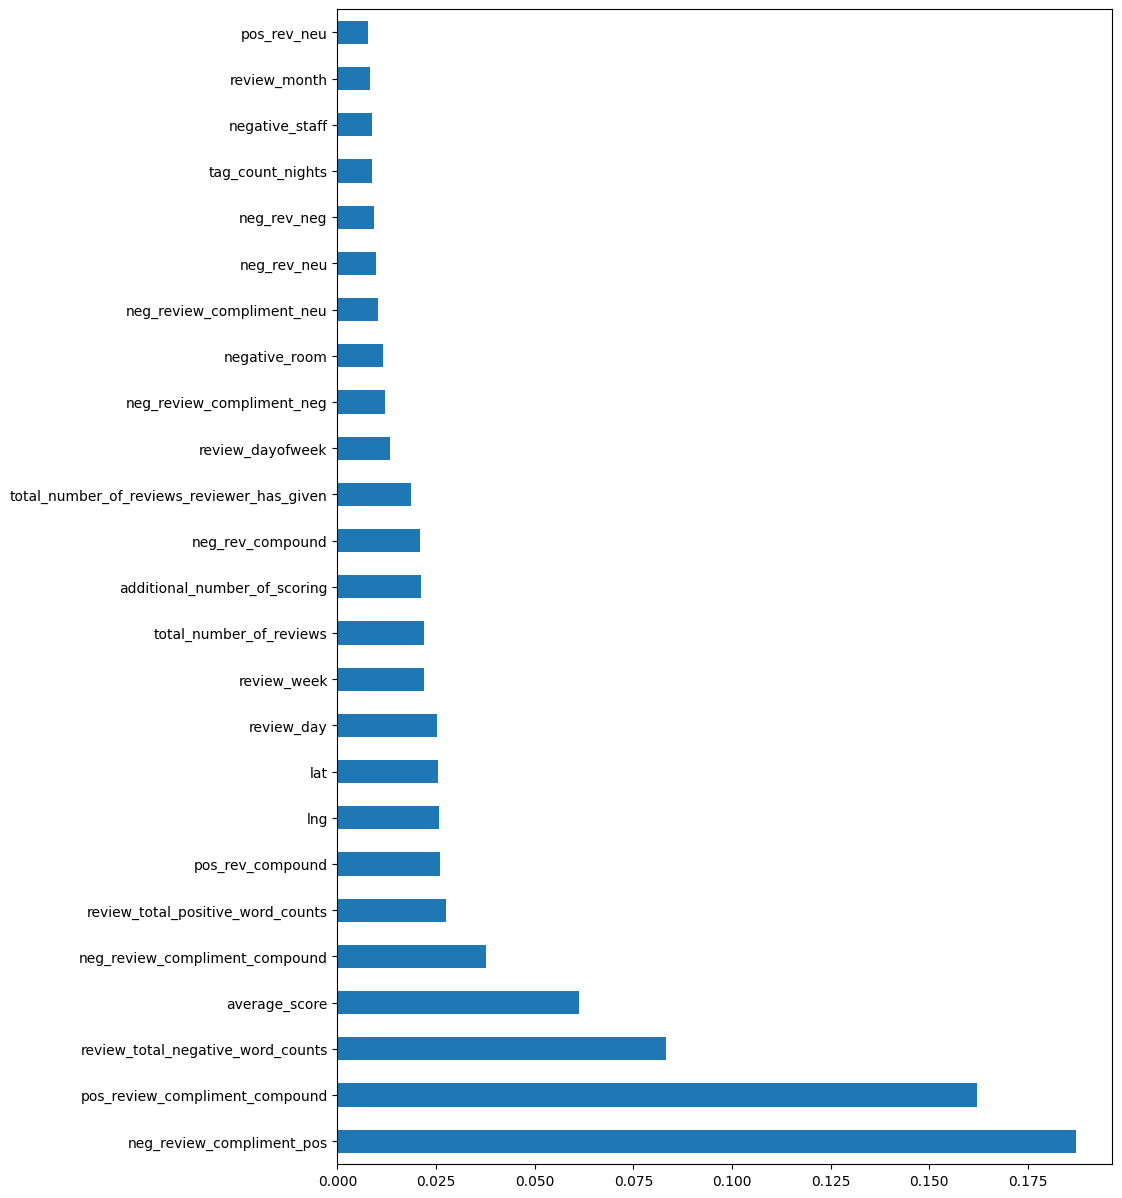

In [247]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели

plt.rcParams['figure.figsize'] = (10, 15)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh');

In [248]:
test_df.sample(5)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,review_year,...,positive_price,positive_spa,pos_rev_neg,neg_rev_neg,pos_rev_neu,neg_rev_neu,pos_rev_pos,neg_rev_pos,pos_rev_compound,neg_rev_compound
113957,149,8.1,12,1442,18,5,0.0,48.858952,2.367041,2017,...,0,1,0.000,0.000,0.829,0.596,0.171,0.404,0.4754,0.7267
39192,227,6.9,23,747,15,11,0.0,51.606805,0.059042,2016,...,0,0,0.000,0.000,1.000,1.000,0.000,0.000,0.0000,0.0000
42118,704,8.8,34,2617,28,8,0.0,51.520815,-0.091532,2017,...,0,0,0.000,0.000,0.550,1.000,0.450,0.000,0.9390,0.0000
23778,98,7.4,38,597,5,1,0.0,51.502103,-0.187901,2016,...,0,0,0.355,0.186,0.645,0.814,0.000,0.000,-0.2960,-0.7269
10673,421,9.2,0,1740,9,2,0.0,51.517240,-0.122032,2016,...,0,0,0.252,1.000,0.748,0.000,0.000,0.000,-0.4019,-0.7096


In [249]:
# формируем код и удаляем признак "reviewer_score"
data_test= test_df.drop(['reviewer_score'], axis=1)

In [250]:
# формируем код и выводим оценку отелей на основе модели
predict_submission = regr.predict(data_test)
display(predict_submission)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.1s finished


array([8.619, 7.351, 8.338, ..., 7.772, 9.445, 7.021])

In [251]:
sample_submission.head(10)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
5,10,302161
6,10,317079
7,1,13963
8,4,159785
9,10,195089


In [252]:
# записываем в файл submission оценки на основании модели
sample_submission['reviewer_score'] = predict_submission
# записываем файл с оценками
sample_submission.to_csv('submission_predict.csv', index=False)